In [1]:
#import necessary packages
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import itertools
import json
from tqdm import tqdm

C:\Users\matth\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Define helper functions

In [2]:
def add_edge(adj_list, node, target):
    adj_list[int(node)].append(int(target)) 

In [3]:
def create_adj_list(data):
    #initialize adjacency lists
    min_node = min(data['FromNodeId'].tolist() + data['ToNodeId'].tolist())
    max_node = max(data['FromNodeId'].tolist() + data['ToNodeId'].tolist())

    adj_list_away = {}
    adj_list_toward = {}

    for node in range(min_node, max_node+1):
        adj_list_away[node] = []
        adj_list_toward[node] = []
        
    for idx, row in data.iterrows():
        add_edge(adj_list_away, row.FromNodeId, row.ToNodeId)
        add_edge(adj_list_toward, row.ToNodeId, row.FromNodeId)
        
    return adj_list_away, adj_list_toward

# Read in and clean the data

### City Reachability

In [85]:
city = pd.read_csv('City Reachability/reachability.txt', header = 5, delimiter = ' ')

#fix column names
city = city.rename(columns = {'#': 'FromNodeId', 'FromNodeId': 'ToNodeId', 'ToNodeId': 'Weight', 'Weight': 'redundant'})
city = city[city.columns[:-1]]

In [86]:
pd.concat([city['ToNodeId'], city['FromNodeId']]).unique().shape

(456,)

In [87]:
city

,FromNodeId,ToNodeId,Weight
0,27,0,-757
1,57,0,-84
2,70,0,-1290
3,74,0,-465
4,86,0,-700
...,...,...,...
71954,419,455,-154
71955,428,455,-341
71956,434,455,-403
71957,440,455,-680


In [88]:
#adjacency list away consists of edges going AWAY a certain node
#adjacency list toward consists of edges going TOWARD a certain node
city_adj_list_away, city_adj_list_toward = create_adj_list(city)

### Stanford Web

In [47]:
# stanford = pd.read_csv('Stanford Web/web-Stanford.txt', header = 3, delimiter = '\t')

In [48]:
# stanford

In [49]:
#creating adj lists takes a while, avoid running if possible

#stanford_adj_list_away, stanford_adj_list_toward = create_adj_list(stanford)

In [50]:
# #saved the adj lists for future use

# with open('Stanford Web/adj_list_away.json', 'r') as fp:
#     stanford_adj_list_away = json.load(fp)
    
# with open('Stanford Web/adj_list_toward.json', 'r') as fp:
#     stanford_adj_list_toward = json.load(fp)

In [51]:
# stanford_adj_list_away, stanford_adj_list_toward = create_adj_list(stanford)

### High-Energy Physics

In [52]:
physics = pd.read_csv('High Energy Physics/Cit-HepPh.txt', delimiter = '\t', header = 3)

In [53]:
physics

,FromNodeId,ToNodeId
0,9907233,9301253
1,9907233,9504304
2,9907233,9505235
3,9907233,9506257
4,9907233,9606402
...,...,...
421573,9912461,9305269
421574,9912461,9609445
421575,9912461,9902379
421576,9912461,9902403


In [54]:
np.unique(physics["FromNodeId"].unique().tolist() + physics["ToNodeId"].unique().tolist()).shape

(34546,)

In [55]:
#adjacency list away consists of edges going AWAY a certain node
#adjacency list toward consists of edges going TOWARD a certain node
physics_adj_list_away, physics_adj_list_toward = create_adj_list(physics)

## EU Email Core

In [56]:
email = pd.read_csv('EU Email Core/email-Eu-core.txt', delimiter = ' ', header = None).rename(columns = {0: 'FromNodeId',
                                                                                                         1: 'ToNodeId'})

In [57]:
email

,FromNodeId,ToNodeId
0,0,1
1,2,3
2,2,4
3,5,6
4,5,7
...,...,...
25566,420,143
25567,174,859
25568,440,460
25569,52,786


In [58]:
np.unique(email["FromNodeId"].unique().tolist() + email["ToNodeId"].unique().tolist()).shape

(1005,)

In [59]:
#adjacency list away consists of edges going AWAY a certain node
#adjacency list toward consists of edges going TOWARD a certain node
email_adj_list_away, email_adj_list_toward = create_adj_list(email)

## Bitcoin Alpha

In [67]:
bitcoin = pd.read_csv('Bitcoin Alpha/soc-sign-bitcoinalpha.csv', header = None, usecols = [0,1]).rename(columns = 
                                                                                                        {0: 'FromNodeId',
                                                                                                         1: 'ToNodeId'})

In [68]:
bitcoin

,FromNodeId,ToNodeId
0,7188,1
1,430,1
2,3134,1
3,3026,1
4,3010,1
...,...,...
24181,7604,7601
24182,7601,7604
24183,7604,7602
24184,7602,7604


In [69]:
np.unique(bitcoin["FromNodeId"].unique().tolist() + bitcoin["ToNodeId"].unique().tolist()).shape

(3783,)

In [70]:
#adjacency list away consists of edges going AWAY a certain node
#adjacency list toward consists of edges going TOWARD a certain node
bitcoin_adj_list_away, bitcoin_adj_list_toward = create_adj_list(bitcoin)

## Wiki-Vote

In [4]:
wiki = pd.read_csv('Wiki-Vote/Wiki-Vote.txt', delimiter = '\t')

In [5]:
np.unique(wiki["FromNodeId"].unique().tolist() + wiki["ToNodeId"].unique().tolist()).shape

(7115,)

In [6]:
#adjacency list away consists of edges going AWAY a certain node
#adjacency list toward consists of edges going TOWARD a certain node
wiki_adj_list_away, wiki_adj_list_toward = create_adj_list(wiki)

# Define counting functions (naive method)

In [63]:
def count_M1(adj_list_away, adj_list_toward):

    vertices = [] #store vertices
    
    print("count vertices")
    for vertex1 in tqdm(adj_list_away): #checks first vertex
        for vertex2 in adj_list_away[vertex1]: #checks second vertex
            for vertex3 in adj_list_away[vertex2]: #checks third vertex
                
                #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                    break
                
#                 if ((vertex1 in adj_list_away[vertex3]) & (vertex1 not in adj_list_toward[vertex3])
#                     & (vertex3 not in adj_list_toward[vertex2]) & (vertex2 not in adj_list_toward[vertex1])):
                    
                if ((vertex1 in adj_list_away[vertex3])):
                    
                    vertices.append([vertex1, vertex2, vertex3])
    
      
    triangles = set(tuple(sorted(l)) for l in vertices) #get rid of permutations of the same triangle
    
    edge_dict = {}

    print("count edges")
    for tri in tqdm(triangles):
        
        combos = list(itertools.combinations(tri, 2))

        for edge in combos:

            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                edge_dict[edge] = 1
            else:                            #if edge does exist
                edge_dict[edge] += 1 #add to edge count

    print('Vertices: ' + str(len(vertices)))
    print('Triangles: ' + str(len(triangles)))
    return len(triangles), edge_dict

In [64]:
def count_M2(adj_list_away, adj_list_toward):

    vertices = []
    
    for vertex1 in tqdm(adj_list_away): #checks first vertex
        for vertex2 in adj_list_away[vertex1]: #checks second vertex
            for vertex3 in adj_list_away[vertex2]: #checks third vertex
                
                #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                    break
                
#                 if ((vertex1 in adj_list_away[vertex3]) & (vertex1 not in adj_list_toward[vertex3])
#                     & (vertex3 not in adj_list_toward[vertex2]) & (vertex2 in adj_list_toward[vertex1])):
                    
                if ((vertex1 in adj_list_away[vertex3]) & (vertex2 in adj_list_toward[vertex1])):
                    
                    vertices.append([vertex1, vertex2, vertex3])
                    
    triangles = set(tuple(sorted(l)) for l in vertices) #get rid of permutations of the same triangle

    edge_dict = {}
    print("count edges")
    for tri in tqdm(triangles):
        
        combos = list(itertools.combinations(tri, 2))

        for edge in combos:

            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                edge_dict[edge] = 1
            else:                            #if edge does exist
                edge_dict[edge] += 1 #add to edge count

    print('Vertices: ' + str(len(vertices)))
    print('Triangles: ' + str(len(triangles)))
    return len(triangles), edge_dict

In [65]:
def count_M3(adj_list_away, adj_list_toward):

    vertices = []
    
    for vertex1 in tqdm(adj_list_away): #checks first vertex
        for vertex2 in adj_list_away[vertex1]: #checks second vertex
            for vertex3 in adj_list_away[vertex2]: #checks third vertex
                
                #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                    break
                
#                 if ((vertex1 in adj_list_away[vertex3]) & (vertex1 not in adj_list_toward[vertex3])
#                     & (vertex3 in adj_list_toward[vertex2]) & (vertex2 in adj_list_toward[vertex1])):
                    
                if ((vertex1 in adj_list_away[vertex3]) & (vertex3 in adj_list_toward[vertex2]) 
                    & (vertex2 in adj_list_toward[vertex1])):
                    
                    vertices.append([vertex1, vertex2, vertex3])
                    
    triangles = set(tuple(sorted(l)) for l in vertices) #get rid of permutations of the same triangle
    
    edge_dict = {}
    print("count edges")
    for tri in tqdm(triangles):
        
        combos = list(itertools.combinations(tri, 2))

        for edge in combos:

            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                edge_dict[edge] = 1
            else:                            #if edge does exist
                edge_dict[edge] += 1 #add to edge count
 
    print('Vertices: ' + str(len(vertices)))
    print('Triangles: ' + str(len(triangles)))
    return len(triangles), edge_dict

In [66]:
def count_M4(adj_list_away, adj_list_toward):

    vertices = []
    
    for vertex1 in tqdm(adj_list_away): #checks first vertex
        for vertex2 in adj_list_away[vertex1]: #checks second vertex
            for vertex3 in adj_list_away[vertex2]: #checks third vertex
                
                #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                    break
                
                if ((vertex1 in adj_list_away[vertex3]) & (vertex1 in adj_list_toward[vertex3])
                    & (vertex3 in adj_list_toward[vertex2]) & (vertex2 in adj_list_toward[vertex1])
                    & (vertex1 != vertex2) & (vertex1 != vertex3) & (vertex2 != vertex3)):
                    
                    vertices.append([vertex1, vertex2, vertex3])
                    
    triangles = set(tuple(sorted(l)) for l in vertices) #get rid of permutations of the same triangle
    
    edge_dict = {}
    print("count edges")
    for tri in tqdm(triangles):
        
        combos = list(itertools.combinations(tri, 2))

        for edge in combos:

            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                edge_dict[edge] = 1
            else:                            #if edge does exist
                edge_dict[edge] += 1 #add to edge count

    print('Vertices: ' + str(len(vertices)))
    print('Triangles: ' + str(len(triangles)))
    return len(triangles), edge_dict

In [67]:
def count_M5(adj_list_away, adj_list_toward):
    
    vertices = []
    
    for vertex1 in tqdm(adj_list_away): #checks first vertex
        for vertex2 in adj_list_away[vertex1]: #checks second vertex
            for vertex3 in adj_list_away[vertex2]: #checks third vertex
                
                #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                    break
                
#                 if ((vertex3 in adj_list_away[vertex2]) & (vertex3 not in adj_list_toward[vertex2])
#                     & (vertex2 not in adj_list_toward[vertex1]) & (vertex3 not in adj_list_toward[vertex1])):
                    
                if ((vertex3 in adj_list_away[vertex1])):
                    
                    vertices.append([vertex1, vertex2, vertex3])
                    
    triangles = set(tuple(sorted(l)) for l in vertices) #get rid of permutations of the same triangle
    
    edge_dict = {}
    print("count edges")
    for tri in tqdm(triangles):
        
        combos = list(itertools.combinations(tri, 2))

        for edge in combos:

            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                edge_dict[edge] = 1
            else:                            #if edge does exist
                edge_dict[edge] += 1 #add to edge count
                
    print('Vertices: ' + str(len(vertices)))
    print('Triangles: ' + str(len(triangles)))
    return len(triangles), edge_dict

In [68]:
def count_M6(adj_list_away, adj_list_toward):
    
    vertices = []
    
    for vertex1 in tqdm(adj_list_away): #checks first vertex
        for vertex2 in adj_list_away[vertex1]: #checks second vertex
            for vertex3 in adj_list_away[vertex2]: #checks third vertex
                
                #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                    break
                
#                 if ((vertex3 in adj_list_away[vertex2]) & (vertex3 in adj_list_toward[vertex2])
#                     & (vertex2 not in adj_list_toward[vertex1]) & (vertex3 not in adj_list_toward[vertex1])):
                    
                if ((vertex3 in adj_list_away[vertex1]) & (vertex3 in adj_list_toward[vertex2])):
                    
                    vertices.append([vertex1, vertex2, vertex3])
                    
    triangles = set(tuple(sorted(l)) for l in vertices) #get rid of permutations of the same triangle
    
    edge_dict = {}
    print("count edges")
    for tri in tqdm(triangles):
        
        combos = list(itertools.combinations(tri, 2))

        for edge in combos:

            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                edge_dict[edge] = 1
            else:                            #if edge does exist
                edge_dict[edge] += 1 #add to edge count

    print('Vertices: ' + str(len(vertices)))
    print('Triangles: ' + str(len(triangles)))
    return len(triangles), edge_dict

In [69]:
def count_M7(adj_list_away, adj_list_toward):
    
    vertices = []
    
    for vertex1 in tqdm(adj_list_away): #checks first vertex
        for vertex2 in adj_list_away[vertex1]: #checks second vertex
            for vertex3 in adj_list_away[vertex2]: #checks third vertex
                
                #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                    break
                
#                 if ((vertex2 not in adj_list_away[vertex1]) & (vertex3 not in adj_list_away[vertex1])
#                    & (vertex2 in adj_list_away[vertex3]) & (vertex3 in adj_list_away[vertex2])):
                    
                if ((vertex3 in adj_list_away[vertex1]) & (vertex1 in adj_list_away[vertex2])):
                    
                    vertices.append([vertex1, vertex2, vertex3])
                    
    triangles = set(tuple(sorted(l)) for l in vertices) #get rid of permutations of the same triangle
    
    edge_dict = {}
    print("count edges")
    for tri in tqdm(triangles):
        
        combos = list(itertools.combinations(tri, 2))

        for edge in combos:

            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                edge_dict[edge] = 1
            else:                            #if edge does exist
                edge_dict[edge] += 1 #add to edge count

    print('Vertices: ' + str(len(vertices)))
    print('Triangles: ' + str(len(triangles)))
    return len(triangles), edge_dict

In [14]:
def count_M8(adj_list_away, adj_list_toward):

    vertices = []
    
    for vertex1 in tqdm(adj_list_away): #checks first vertex
        for vertex2 in adj_list_away[vertex1]: #checks second vertex
            for vertex3 in adj_list_away[vertex1]: #checks third vertex
                
                #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                    break

                if ((vertex3 not in adj_list_away[vertex2]) & (vertex3 not in adj_list_toward[vertex2])
                    & (vertex2 not in adj_list_toward[vertex1]) & (vertex3 not in adj_list_toward[vertex1])
                    & (vertex2 != vertex3)):

                    vertices.append([vertex1, vertex2, vertex3])

    triangles = set(tuple(sorted(l)) for l in vertices) #get rid of permutations of the same triangle

    edge_dict = {}
    print("count edges")
    for tri in tqdm(triangles):

        combos = list(itertools.combinations(tri, 2))

        for edge in combos:

            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                edge_dict[edge] = 1
            else: #if edge does exist
                edge_dict[edge] += 1 #add to edge count

    print('Vertices: ' + str(len(vertices)))
    print('Triangles: ' + str(len(triangles)))
    return len(triangles), edge_dict

In [15]:
def count_M9(adj_list_away, adj_list_toward):
    
    vertices = []
    
    for vertex1 in tqdm(adj_list_away): #checks first vertex
        for vertex2 in adj_list_away[vertex1]: #checks second vertex
            for vertex3 in adj_list_away[vertex2]: #check third vertex
                
                #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                    break
                
                if ((vertex1 not in adj_list_away[vertex3]) & (vertex1 not in adj_list_toward[vertex3])
                    & (vertex3 not in adj_list_toward[vertex2]) & (vertex2 not in adj_list_toward[vertex1])
                    & (vertex1 != vertex3)):
                    
                    vertices.append([vertex1, vertex2, vertex3])
                    
    triangles = set(tuple(sorted(l)) for l in vertices) #get rid of permutations of the same triangle
    
    edge_dict = {}
    print("count edges")
    for tri in tqdm(triangles):
        
        combos = list(itertools.combinations(tri, 2))

        for edge in combos:

            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                edge_dict[edge] = 1
            else:                            #if edge does exist
                edge_dict[edge] += 1 #add to edge count
    
    print('Vertices: ' + str(len(vertices)))
    print('Triangles: ' + str(len(triangles)))
    return len(triangles), edge_dict

In [16]:
def count_M10(adj_list_away, adj_list_toward):

    vertices = []
    print("start motif counting")
    for vertex1 in tqdm(adj_list_away): #checks first vertex
        for vertex2 in adj_list_toward[vertex1]: #checks second vertex
            for vertex3 in adj_list_toward[vertex1]: #checks third vertex

                #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                    break
                
                if ((vertex2 not in adj_list_away[vertex1]) & (vertex3 not in adj_list_away[vertex1])
                    & (vertex2 not in adj_list_away[vertex3]) & (vertex3 not in adj_list_away[vertex2])
                    & (vertex2 != vertex3) & (vertex2 != vertex1) & (vertex1 != vertex3)):

                    vertices.append([vertex1, vertex2, vertex3])
    
    print('Number of triangles before the set operations: ' + str(len(vertices)))        
    triangles = set(tuple(sorted(l)) for l in vertices) #get rid of permutations of the same triangle
    
    edge_dict = {}
    print("count edges")
    for tri in tqdm(triangles):
        
        combos = list(itertools.combinations(tri, 2))

        for edge in combos:

            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                edge_dict[edge] = 1
            else:                            #if edge does exist
                edge_dict[edge] += 1 #add to edge count

    print('Vertices: ' + str(len(vertices)))
    print('Triangles: ' + str(len(triangles)))
    return len(triangles), edge_dict

In [17]:
def count_M11(adj_list_away, adj_list_toward):

    vertices = []
    
    for vertex1 in tqdm(adj_list_away): #checks first vertex
        for vertex2 in adj_list_away[vertex1]: #checks second vertex
            for vertex3 in adj_list_away[vertex1]: #checks third vertex
                
                #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                    break

                if ((vertex3 not in adj_list_away[vertex2]) & (vertex3 not in adj_list_toward[vertex2])
                    & (vertex2 in adj_list_toward[vertex1]) & (vertex3 not in adj_list_toward[vertex1])
                    & (vertex2 != vertex3)):

                    vertices.append([vertex1, vertex2, vertex3])

    triangles = set(tuple(sorted(l)) for l in vertices) #get rid of permutations of the same triangle

    edge_dict = {}
    print("count edges")
    for tri in tqdm(triangles):

        combos = list(itertools.combinations(tri, 2))

        for edge in combos:

            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                edge_dict[edge] = 1
            else: #if edge does exist
                edge_dict[edge] += 1 #add to edge count
                
    print('Vertices: ' + str(len(vertices)))
    print('Triangles: ' + str(len(triangles)))
    return len(triangles), edge_dict

In [18]:
def count_M12(adj_list_away, adj_list_toward):
    
    vertices = []
    
    for vertex1 in tqdm(adj_list_away): #checks first vertex
        for vertex2 in adj_list_away[vertex1]: #checks second vertex
            for vertex3 in adj_list_away[vertex2]: #checks third vertex
                
                #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                    break
                
                if ((vertex1 not in adj_list_away[vertex3]) & (vertex1 not in adj_list_toward[vertex3])
                    & (vertex3 in adj_list_toward[vertex2]) & (vertex2 not in adj_list_toward[vertex1])
                    & (vertex1 != vertex3)):
                    
                    vertices.append([vertex1, vertex2, vertex3])
                    
    triangles = set(tuple(sorted(l)) for l in vertices) #get rid of permutations of the same triangle
    
    edge_dict = {}
    print("count edges")
    for tri in tqdm(triangles):
        
        combos = list(itertools.combinations(tri, 2))

        for edge in combos:

            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                edge_dict[edge] = 1
            else:                            #if edge does exist
                edge_dict[edge] += 1 #add to edge count
    
    print('Vertices: ' + str(len(vertices)))
    print('Triangles: ' + str(len(triangles)))
    return len(triangles), edge_dict

In [19]:
def count_M13(adj_list_away, adj_list_toward):

    vertices = []
    
    for vertex1 in tqdm(adj_list_away): #checks first vertex
        for vertex2 in adj_list_away[vertex1]: #checks second vertex
            for vertex3 in adj_list_away[vertex1]: #checks third vertex
                
                #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                    break

                if ((vertex3 not in adj_list_away[vertex2]) & (vertex3 not in adj_list_toward[vertex2])
                    & (vertex2 in adj_list_toward[vertex1]) & (vertex3 in adj_list_toward[vertex1])
                    & (vertex2 != vertex3)):

                    vertices.append([vertex1, vertex2, vertex3])

    triangles = set(tuple(sorted(l)) for l in vertices) #get rid of permutations of the same triangle

    edge_dict = {}
    print("count edges")
    for tri in tqdm(triangles):

        combos = list(itertools.combinations(tri, 2))

        for edge in combos:

            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                edge_dict[edge] = 1
            else: #if edge does exist
                edge_dict[edge] += 1 #add to edge count
    print('Vertices: ' + str(len(vertices)))
    print('Triangles: ' + str(len(triangles)))
    return len(triangles), edge_dict

# Define counting functions (sampling method)

In [20]:
def sampling_count_M1(adj_list_away, adj_list_toward, threshold):

    vertices = [] #store vertices
    
    sample_count = 0
    normal_count = 0
    edge_dict = {}
    
    for vertex1 in tqdm(adj_list_away): #checks each starting vertex
        for vertex2 in adj_list_away[vertex1]: #access all possible nodes (vertex 2) from vertex 1
            
            if len(adj_list_away[vertex2]) > threshold: #if the third vertex has a high enough degree, sample
                sampled_nodes = np.random.choice(adj_list_away[vertex2], threshold)
            
                for vertex3 in sampled_nodes:

                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex1 in adj_list_away[vertex3])):

                        vertices.append([vertex1, vertex2, vertex3])
                        temp_count = (1/(threshold/len(adj_list_away[vertex2])))
                        sample_count += temp_count
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = temp_count
                            else:                            #if edge does exist
                                edge_dict[edge] += temp_count #add to edge count
                        
            else: #if the degree is lower than the threshold, sample like normal
                
                for vertex3 in adj_list_away[vertex2]: #checks third vertex
                
                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex1 in adj_list_away[vertex3])):

                        vertices.append([vertex1, vertex2, vertex3])
                        normal_count += 1
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = 1
                            else:                            #if edge does exist
                                edge_dict[edge] += 1 #add to edge count
    
    final_count = (sample_count+normal_count)/3
    
    return final_count, edge_dict

In [21]:
def sampling_count_M2(adj_list_away, adj_list_toward, threshold):

    vertices = [] #store vertices
    
    sample_count = 0
    normal_count = 0
    edge_dict = {}
    
    for vertex1 in tqdm(adj_list_away): #checks each starting vertex
        for vertex2 in adj_list_away[vertex1]: #access all possible nodes (vertex 2) from vertex 1
            
            if len(adj_list_away[vertex2]) > threshold: #if the third vertex has a high enough degree, sample
                sampled_nodes = np.random.choice(adj_list_away[vertex2], threshold)
            
                for vertex3 in sampled_nodes:

                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex1 in adj_list_away[vertex3]) & (vertex2 in adj_list_toward[vertex1])
                        & (vertex3 in adj_list_away[vertex2])):

                        vertices.append([vertex1, vertex2, vertex3])
                        temp_count = (1/(threshold/len(adj_list_away[vertex2])))
                        sample_count += temp_count
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = temp_count
                            else:                            #if edge does exist
                                edge_dict[edge] += temp_count #add to edge count
                        
            else: #if the degree is lower than the threshold, sample like normal
                
                for vertex3 in adj_list_away[vertex2]: #checks third vertex
                
                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex1 in adj_list_away[vertex3]) & ((vertex2 in adj_list_toward[vertex1])
                        & (vertex3 in adj_list_away[vertex2])):

                        vertices.append([vertex1, vertex2, vertex3])
                        normal_count += 1
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = 1
                            else:                            #if edge does exist
                                edge_dict[edge] += 1 #add to edge count
     
    final_count = sample_count+normal_count
    
    return final_count, edge_dict

In [22]:
def sampling_count_M3(adj_list_away, adj_list_toward, threshold):

    vertices = [] #store vertices
    
    sample_count = 0
    normal_count = 0
    edge_dict = {}
    
    for vertex1 in tqdm(adj_list_away): #checks each starting vertex
        for vertex2 in adj_list_away[vertex1]: #access all possible nodes (vertex 2) from vertex 1
            
            if len(adj_list_away[vertex2]) > threshold: #if the third vertex has a high enough degree, sample
                sampled_nodes = np.random.choice(adj_list_away[vertex2], threshold)
            
                for vertex3 in sampled_nodes:

                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex1 in adj_list_away[vertex3]) & (vertex3 in adj_list_toward[vertex2]) 
                        & (vertex2 in adj_list_toward[vertex1]) & (vertex3 in adj_list_away[vertex2])):

                        vertices.append([vertex1, vertex2, vertex3])
                        temp_count = (1/(threshold/len(adj_list_away[vertex2])))
                        sample_count += temp_count
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = temp_count
                            else:                            #if edge does exist
                                edge_dict[edge] += temp_count #add to edge count
                        
            else: #if the degree is lower than the threshold, sample like normal
                
                for vertex3 in adj_list_away[vertex2]: #checks third vertex
                
                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex1 in adj_list_away[vertex3]) & (vertex3 in adj_list_toward[vertex2]) 
                        & (vertex2 in adj_list_toward[vertex1]) & (vertex3 in adj_list_away[vertex2])):

                        vertices.append([vertex1, vertex2, vertex3])
                        normal_count += 1
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = 1
                            else:                            #if edge does exist
                                edge_dict[edge] += 1 #add to edge count
    
    final_count = sample_count+normal_count
    
    return final_count, edge_dict

In [23]:
def sampling_count_M4(adj_list_away, adj_list_toward, threshold):

    vertices = []
    
    sample_count = 0
    normal_count = 0
    edge_dict = {}
    
    for vertex1 in tqdm(adj_list_away): #checks each starting vertex
        for vertex2 in adj_list_away[vertex1]: #access all possible nodes (vertex 2) from vertex 1
            
            if len(adj_list_away[vertex2]) > threshold: #if the third vertex has a high enough degree, sample
                sampled_nodes = np.random.choice(adj_list_away[vertex2], threshold)
            
                #randomly sample a third vertex at uniform from all possible nodes
                for vertex3 in sampled_nodes:

                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex1 in adj_list_away[vertex3]) & (vertex1 in adj_list_toward[vertex3])
                        & (vertex3 in adj_list_toward[vertex2]) & (vertex2 in adj_list_toward[vertex1])
                        & (vertex1 != vertex2) & (vertex1 != vertex3) & (vertex2 != vertex3)
                        & (vertex3 in adj_list_away[vertex2])):

                        vertices.append([vertex1, vertex2, vertex3])
                        temp_count = (1/(threshold/len(adj_list_away[vertex2])))
                        sample_count += temp_count
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = temp_count
                            else:                            #if edge does exist
                                edge_dict[edge] += temp_count #add to edge count
                
                        
            else: #if the degree is lower than the threshold, sample like normal
                
                for vertex3 in adj_list_away[vertex2]: #checks third vertex
                
                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex1 in adj_list_away[vertex3]) & (vertex1 in adj_list_toward[vertex3])
                        & (vertex3 in adj_list_toward[vertex2]) & (vertex2 in adj_list_toward[vertex1])
                        & (vertex1 != vertex2) & (vertex1 != vertex3) & (vertex2 != vertex3)
                        & (vertex3 in adj_list_away[vertex2])):

                        vertices.append([vertex1, vertex2, vertex3])
                        normal_count += 1
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = 1
                            else:                            #if edge does exist
                                edge_dict[edge] += 1 #add to edge count
    
    final_count = (sample_count+normal_count)/6
    
    return final_count, edge_dict

In [24]:
def sampling_count_M5(adj_list_away, adj_list_toward, threshold):
    
    vertices = []
    
    sample_count = 0
    normal_count = 0
    edge_dict = {}
    
    for vertex1 in tqdm(adj_list_away): #checks each parent node
        for vertex2 in adj_list_away[vertex1]: #checks first child node
            
            if len(adj_list_away[vertex2]) > threshold: #if the third vertex has a high enough degree, sample
                sampled_nodes = np.random.choice(adj_list_away[vertex2], threshold)
            
                #randomly sample a third vertex at uniform from all possible nodes
                for vertex3 in sampled_nodes:

                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex3 in adj_list_away[vertex1])):

                        vertices.append([vertex1, vertex2, vertex3])
                        temp_count = (1/(threshold/len(adj_list_away[vertex2])))
                        sample_count += temp_count
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = temp_count
                            else:                            #if edge does exist
                                edge_dict[edge] += temp_count #add to edge count
                        
            else: #if the degree is lower than the threshold, sample like normal
                
                for vertex3 in adj_list_away[vertex2]:

                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex3 in adj_list_away[vertex1])):

                        vertices.append([vertex1, vertex2, vertex3])
                        normal_count += 1
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = 1
                            else:                            #if edge does exist
                                edge_dict[edge] += 1 #add to edge count
    
    final_count = sample_count+normal_count
    
    return final_count, edge_dict

In [130]:
def sampling_count_M6(adj_list_away, adj_list_toward, threshold):
    
    vertices = []
    
    sample_count = 0
    normal_count = 0
    edge_dict = {}
    
    for vertex1 in tqdm(adj_list_away): #checks each parent node
        for vertex2 in adj_list_away[vertex1]: #checks first child node
            
            if len(adj_list_away[vertex2]) > threshold: #if the third vertex has a high enough degree, sample
                sampled_nodes = np.random.choice(adj_list_away[vertex2], threshold)
            
                #randomly sample a third vertex at uniform from all possible nodes
                for vertex3 in sampled_nodes:

                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex3 in adj_list_away[vertex1]) & (vertex3 in adj_list_toward[vertex2])):

                        vertices.append([vertex1, vertex2, vertex3])
                        temp_count = (1/(threshold/len(adj_list_away[vertex2])))
                        sample_count += temp_count
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = temp_count
                            else:                            #if edge does exist
                                edge_dict[edge] += temp_count #add to edge count
                        
            else: #if the degree is lower than the threshold, sample like normal
                
                for vertex3 in adj_list_away[vertex2]:

                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex3 in adj_list_away[vertex1]) & (vertex3 in adj_list_toward[vertex2])):

                        vertices.append([vertex1, vertex2, vertex3])
                        normal_count += 1
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = 1
                            else:                            #if edge does exist
                                edge_dict[edge] += 1 #add to edge count
                                
    final_count = (sample_count+normal_count)/2
    
    return final_count, edge_dict

In [131]:
def sampling_count_M7(adj_list_away, adj_list_toward, threshold):
    
    vertices = []
    
    sample_count = 0
    normal_count = 0
    edge_dict = {}
    
    for vertex1 in tqdm(adj_list_away): #checks each parent node
        for vertex2 in adj_list_away[vertex1]: #checks first child node
            
            if len(adj_list_away[vertex2]) > threshold: #if the third vertex has a high enough degree, sample
                sampled_nodes = np.random.choice(adj_list_away[vertex2], threshold)
            
                #randomly sample a third vertex at uniform from all possible nodes
                for vertex3 in sampled_nodes:  

                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex3 in adj_list_away[vertex1]) & (vertex1 in adj_list_away[vertex2])):

                        vertices.append([vertex1, vertex2, vertex3])
                        temp_count = (1/(threshold/len(adj_list_away[vertex2])))
                        sample_count += temp_count
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = temp_count
                            else:                            #if edge does exist
                                edge_dict[edge] += temp_count #add to edge count
                        
            else:
                
                for vertex3 in adj_list_away[vertex2]: #checks third vertex
                    
                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex3 in adj_list_away[vertex1]) & (vertex1 in adj_list_away[vertex2])):

                        vertices.append([vertex1, vertex2, vertex3])
                        normal_count += 1
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = 1
                            else:                            #if edge does exist
                                edge_dict[edge] += 1 #add to edge count
      
    final_count = (sample_count+normal_count)/2
    
    return final_count, edge_dict

In [27]:
def sampling_count_M8(adj_list_away, adj_list_toward, threshold):

    vertices = []
    
    sample_count = 0
    normal_count = 0
    edge_dict = {}
    
    for vertex1 in adj_list_away: #checks each vertex1 node
        for vertex2 in adj_list_away[vertex1]: #checks first child node
            
            if len(adj_list_away[vertex1]) > threshold: #if the third vertex has a high enough degree, sample
                sampled_nodes = np.random.choice(adj_list_away[vertex1], threshold)
            
                #randomly sample a third vertex at uniform from all possible nodes
                for vertex3 in sampled_nodes: 

                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex3 not in adj_list_away[vertex2]) & (vertex3 not in adj_list_toward[vertex2])
                        & (vertex2 not in adj_list_toward[vertex1]) & (vertex3 not in adj_list_toward[vertex1])
                        & (vertex2 != vertex3) & (vertex3 in adj_list_away[vertex1])):

                        vertices.append([vertex1, vertex2, vertex3])
                        temp_count = (1/(threshold/len(adj_list_away[vertex1])))
                        sample_count += temp_count
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = temp_count
                            else:                            #if edge does exist
                                edge_dict[edge] += temp_count #add to edge count
                        
            else:
                
                for vertex3 in adj_list_away[vertex1]:
                    
                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex3 not in adj_list_away[vertex2]) & (vertex3 not in adj_list_toward[vertex2])
                        & (vertex2 not in adj_list_toward[vertex1]) & (vertex3 not in adj_list_toward[vertex1])
                        & (vertex2 != vertex3) & (vertex3 in adj_list_away[vertex1])):

                        vertices.append([vertex1, vertex2, vertex3])
                        normal_count += 1
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = 1
                            else:                            #if edge does exist
                                edge_dict[edge] += 1 #add to edge count
    
    final_count = (sample_count+normal_count)/2
    
    return final_count, edge_dict

In [28]:
def sampling_count_M9(adj_list_away, adj_list_toward, threshold):
    
    vertices = []
    
    sample_count = 0
    normal_count = 0
    edge_dict = {}
    
    for vertex1 in tqdm(adj_list_away): #checks each starting vertex
        for vertex2 in adj_list_away[vertex1]: #access all possible nodes (vertex 2) from vertex 1
            
            if len(adj_list_away[vertex2]) > threshold: #if the third vertex has a high enough degree, sample
                sampled_nodes = np.random.choice(adj_list_away[vertex2], threshold)
            
                #randomly sample a third vertex at uniform from all possible nodes
                for vertex3 in sampled_nodes: 

                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex1 not in adj_list_away[vertex3]) & (vertex1 not in adj_list_toward[vertex3])
                        & (vertex3 not in adj_list_toward[vertex2]) & (vertex2 not in adj_list_toward[vertex1])
                        & (vertex1 != vertex3) & (vertex3 in adj_list_away[vertex2])):

                        vertices.append([vertex1, vertex2, vertex3])
                        temp_count = (1/(threshold/len(adj_list_away[vertex2])))
                        sample_count += temp_count
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = temp_count
                            else:                            #if edge does exist
                                edge_dict[edge] += temp_count #add to edge count
                        
            else:
                
                for vertex3 in adj_list_away[vertex2]:
                    
                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex1 not in adj_list_away[vertex3]) & (vertex1 not in adj_list_toward[vertex3])
                        & (vertex3 not in adj_list_toward[vertex2]) & (vertex2 not in adj_list_toward[vertex1])
                        & (vertex1 != vertex3) & (vertex3 in adj_list_away[vertex2])):

                        vertices.append([vertex1, vertex2, vertex3])
                        normal_count += 1
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = 1
                            else:                            #if edge does exist
                                edge_dict[edge] += 1 #add to edge count
                    
    final_count = (sample_count+normal_count)
    
    return final_count, edge_dict

In [204]:
def sampling_count_M10(adj_list_away, adj_list_toward, threshold):
    
    vertices = []
    sample_count = 0
    normal_count = 0
    edge_dict = {}
    
    for vertex1 in adj_list_away:#for vertex1 in tqdm(adj_list_away): #checks first vertex
        for vertex2 in adj_list_toward[vertex1]: #checks second vertex
            
            if len(adj_list_toward[vertex1]) > threshold: #if the third vertex has a high enough degree, sample
                sampled_nodes = np.random.choice(adj_list_toward[vertex1], threshold)
                
                #randomly sample a third vertex at uniform from all possible nodes
                for vertex3 in sampled_nodes:

                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex2 not in adj_list_away[vertex1]) & (vertex3 not in adj_list_away[vertex1])
                        & (vertex2 not in adj_list_away[vertex3]) & (vertex3 not in adj_list_away[vertex2])
                        & (vertex2 != vertex3) & (vertex3 in adj_list_toward[vertex1])):

                        vertices.append([vertex1, vertex2, vertex3])
                        temp_count = (1/(threshold/len(adj_list_toward[vertex1])))
                        sample_count += temp_count
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = temp_count
                            else:                            #if edge does exist
                                edge_dict[edge] += temp_count #add to edge count
            
            else: #if the degree is lower than the threshold, sample like normal
                
                for vertex3 in adj_list_toward[vertex1]: #checks third vertex

                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex2 not in adj_list_away[vertex1]) & (vertex3 not in adj_list_away[vertex1])
                        & (vertex2 not in adj_list_away[vertex3]) & (vertex3 not in adj_list_away[vertex2])
                        & (vertex2 != vertex3) & (vertex2 != vertex1) & (vertex1 != vertex3)):

                        vertices.append([vertex1, vertex2, vertex3])
                        normal_count += 1
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = 1
                            else:                            #if edge does exist
                                edge_dict[edge] += 1 #add to edge count  
                        
    final_count = (sample_count+normal_count)/2
    
    return final_count, edge_dict

In [30]:
def sampling_count_M11(adj_list_away, adj_list_toward, threshold):

    vertices = []
    
    sample_count = 0
    normal_count = 0
    edge_dict = {}
    
    for vertex1 in tqdm(adj_list_away): #checks each vertex1 node
        for vertex2 in adj_list_away[vertex1]: #checks first child node
            
            if len(adj_list_away[vertex1]) > threshold: #if the third vertex has a high enough degree, sample
                sampled_nodes = np.random.choice(adj_list_away[vertex1], threshold)
            
                #randomly sample a third vertex at uniform from all possible nodes
                for vertex3 in sampled_nodes:

                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex3 not in adj_list_away[vertex2]) & (vertex3 not in adj_list_toward[vertex2])
                        & (vertex2 in adj_list_toward[vertex1]) & (vertex3 not in adj_list_toward[vertex1])
                        & (vertex2 != vertex3) & (vertex3 in adj_list_away[vertex1])):

                        vertices.append([vertex1, vertex2, vertex3])
                        temp_count = (1/(threshold/len(adj_list_away[vertex1])))
                        sample_count += temp_count
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = temp_count
                            else:                            #if edge does exist
                                edge_dict[edge] += temp_count #add to edge count
                        
            else:
                
                for vertex3 in adj_list_away[vertex1]:

                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex3 not in adj_list_away[vertex2]) & (vertex3 not in adj_list_toward[vertex2])
                        & (vertex2 in adj_list_toward[vertex1]) & (vertex3 not in adj_list_toward[vertex1])
                        & (vertex2 != vertex3) & (vertex3 in adj_list_away[vertex1])):

                        vertices.append([vertex1, vertex2, vertex3])
                        normal_count+=1
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = 1
                            else:                            #if edge does exist
                                edge_dict[edge] += 1 #add to edge count

    final_count = (sample_count+normal_count)
    
    return final_count, edge_dict

In [31]:
def sampling_count_M12(adj_list_away, adj_list_toward, threshold):
    
    vertices = []
    
    sample_count = 0
    normal_count = 0
    edge_dict = {}
    
    for vertex1 in tqdm(adj_list_away): #checks each starting vertex
        for vertex2 in adj_list_away[vertex1]: #access all possible nodes (vertex 2) from vertex 1
            
            if len(adj_list_away[vertex2]) > threshold: #if the third vertex has a high enough degree, sample
                sampled_nodes = np.random.choice(adj_list_away[vertex2], threshold)
            
                #randomly sample a third vertex at uniform from all possible nodes
                for vertex3 in sampled_nodes:

                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex1 not in adj_list_away[vertex3]) & (vertex1 not in adj_list_toward[vertex3])
                        & (vertex3 in adj_list_toward[vertex2]) & (vertex2 not in adj_list_toward[vertex1])
                        & (vertex1 != vertex3) & (vertex3 in adj_list_away[vertex2])):

                        vertices.append([vertex1, vertex2, vertex3])
                        temp_count = (1/(threshold/len(adj_list_away[vertex2])))
                        sample_count += temp_count
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = temp_count
                            else:                            #if edge does exist
                                edge_dict[edge] += temp_count #add to edge count
                        
            else:
                
                for vertex3 in adj_list_away[vertex2]:
                    
                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex1 not in adj_list_away[vertex3]) & (vertex1 not in adj_list_toward[vertex3])
                        & (vertex3 in adj_list_toward[vertex2]) & (vertex2 not in adj_list_toward[vertex1])
                        & (vertex1 != vertex3) & (vertex3 in adj_list_away[vertex2])):

                        vertices.append([vertex1, vertex2, vertex3])
                        normal_count+=1
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = 1
                            else:                            #if edge does exist
                                edge_dict[edge] += 1 #add to edge count
    
    final_count = (sample_count+normal_count)
    
    return final_count, edge_dict

In [32]:
def sampling_count_M13(adj_list_away, adj_list_toward, threshold):

    vertices = []
    
    sample_count = 0
    normal_count = 0
    edge_dict = {}
    
    for vertex1 in tqdm(adj_list_away): #checks each vertex1 node
        for vertex2 in adj_list_away[vertex1]: #checks first child node
            
            if len(adj_list_away[vertex2]) > threshold: #if the third vertex has a high enough degree, sample
                sampled_nodes = np.random.choice(adj_list_away[vertex2], threshold)
            
                #randomly sample a third vertex at uniform from all possible nodes
                for vertex3 in sampled_nodes:

                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex3 not in adj_list_away[vertex1]) & (vertex3 not in adj_list_toward[vertex1])
                        & (vertex2 in adj_list_toward[vertex1]) & (vertex3 in adj_list_toward[vertex2])
                        & (vertex1 != vertex3)):

                        vertices.append([vertex1, vertex2, vertex3])
                        temp_count = (1/(threshold/len(adj_list_away[vertex1])))
                        sample_count += temp_count
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = temp_count
                            else:                            #if edge does exist
                                edge_dict[edge] += temp_count #add to edge count
                        
            else:
                
                for vertex3 in adj_list_away[vertex1]:
                    #if any of the adjacency lists are empty (nan used for placeholder) SKIP this iteration
                    if ( (np.isnan(vertex1)) | (np.isnan(vertex2)) | (np.isnan(vertex3)) ):
                        break

                    if ((vertex3 not in adj_list_away[vertex2]) & (vertex3 not in adj_list_toward[vertex2])
                        & (vertex2 in adj_list_toward[vertex1]) & (vertex3 in adj_list_toward[vertex1])
                        & (vertex2 != vertex3) & (vertex3 in adj_list_away[vertex1])):

                        vertices.append([vertex1, vertex2, vertex3])
                        normal_count+=1
                        
                        combos = list(itertools.combinations([vertex1, vertex2, vertex3], 2))

                        for edge in combos:

                            if edge not in edge_dict.keys(): #if edge doesn't exist yet
                                edge_dict[edge] = 1
                            else:                            #if edge does exist
                                edge_dict[edge] += 1 #add to edge count
    
    final_count = (sample_count+normal_count)/2
    
    return final_count, edge_dict

# Get motif counts (city reachability)

In [134]:
M1_count, edge_dict_M1 = count_M1(city_adj_list_away, city_adj_list_toward)

  0%|          | 0/456 [00:00<?, ?it/s]

count vertices


  3%|▎         | 56956/1781759 [00:00<00:06, 286381.57it/s]

count edges


100%|██████████| 1781759/1781759 [00:06<00:00, 281388.79it/s]

Vertices: 9837009
Triangles: 1781759


In [135]:
M1_count

1781759

In [ ]:
sampling_M1_count, sampling_edge_dict_M1 = sampling_count_M1(city_adj_list_away, city_adj_list_toward, 20)

In [ ]:
sampling_M1_count

In [136]:
M2_count, edge_dict_M2 = count_M2(city_adj_list_away, city_adj_list_toward)

  2%|▏         | 31647/1781527 [00:00<00:05, 316322.48it/s]

count edges


100%|██████████| 1781527/1781527 [00:06<00:00, 294362.37it/s]

Vertices: 9538031
Triangles: 1781527


In [137]:
M2_count

1781527

In [128]:
sampling_M2_count, sampling_edge_dict_M2 = sampling_count_M2(city_all_nodes, city_adj_list_away, city_adj_list_toward, 5)

In [129]:
sampling_M2_count

104

In [138]:
M3_count, edge_dict_M3 = count_M3(city_adj_list_away, city_adj_list_toward)

  2%|▏         | 31234/1767528 [00:00<00:05, 310114.79it/s]

count edges


100%|██████████| 1767528/1767528 [00:06<00:00, 287480.61it/s]


Vertices: 9253748
Triangles: 1767528


In [139]:
M3_count

1767528

In [130]:
sampling_M3_count, sampling_edge_dict_M3 = sampling_count_M3(city_all_nodes, city_adj_list_away, city_adj_list_toward, 5)

In [131]:
sampling_M3_count

1931

In [140]:
M4_count, edge_dict_M4 = count_M4(city_adj_list_away, city_adj_list_toward)

  2%|▏         | 33694/1497244 [00:00<00:04, 335455.11it/s]

count edges


100%|██████████| 1497244/1497244 [00:04<00:00, 303443.52it/s]

Vertices: 8983464
Triangles: 1497244


In [141]:
M4_count

1497244

In [132]:
sampling_M4_count, sampling_edge_dict_M4 = sampling_count_M4(city_all_nodes, city_adj_list_away, city_adj_list_toward, 5)

In [133]:
sampling_M4_count

65497

In [142]:
M5_count, edge_dict_M5 = count_M5(city_adj_list_away, city_adj_list_toward)

  3%|▎         | 61326/1814213 [00:00<00:05, 307123.69it/s]

count edges


100%|██████████| 1814213/1814213 [00:06<00:00, 268571.30it/s]

Vertices: 9872505
Triangles: 1814213


In [143]:
M5_count

1814213

In [278]:
sampling_M5_count, sampling_edge_dict_M5 = sampling_count_M5(city_all_nodes, city_adj_list_away, city_adj_list_toward, 5)

In [279]:
sampling_M5_count

3

In [144]:
M6_count, edge_dict_M6 = count_M6(city_adj_list_away, city_adj_list_toward)

  2%|▏         | 33858/1782639 [00:00<00:05, 336796.89it/s]

count edges


100%|██████████| 1782639/1782639 [00:05<00:00, 300116.16it/s]

Vertices: 9554254
Triangles: 1782639


In [145]:
M6_count

1782639

In [136]:
sampling_M6_count, sampling_edge_dict_M6 = sampling_count_M6(city_all_nodes, city_adj_list_away, city_adj_list_toward, 5)

In [137]:
sampling_M6_count

149

In [146]:
M7_count, edge_dict_M7 = count_M7(city_adj_list_away, city_adj_list_toward)

  3%|▎         | 57856/1783921 [00:00<00:05, 293636.32it/s]

count edges


100%|██████████| 1783921/1783921 [00:05<00:00, 299349.44it/s]

Vertices: 9556818
Triangles: 1783921


In [147]:
M7_count

1783921

In [138]:
sampling_M7_count, sampling_edge_dict_M7 = sampling_count_M7(city_all_nodes, city_adj_list_away, city_adj_list_toward, 5)

In [139]:
sampling_M7_count

189

In [148]:
M8_count, edge_dict_M8 = count_M8(city_adj_list_away, city_adj_list_toward)

100%|██████████| 16013/16013 [00:00<00:00, 395155.47it/s]

count edges
Vertices: 32026
Triangles: 16013


In [149]:
M8_count

16013

In [140]:
sampling_M8_count, sampling_edge_dict_M8 = sampling_count_M8(city_all_nodes, city_adj_list_away, city_adj_list_toward, 5)

In [141]:
sampling_M8_count

457

In [150]:
M9_count, edge_dict_M9 = count_M9(city_adj_list_away, city_adj_list_toward)

100%|██████████| 25124/25124 [00:00<00:00, 395518.86it/s]

count edges
Vertices: 25124
Triangles: 25124


In [151]:
M9_count

25124

In [142]:
sampling_M9_count, sampling_edge_dict_M9 = sampling_count_M9(city_all_nodes, city_adj_list_away, city_adj_list_toward, 5)

In [143]:
sampling_M9_count

199

In [152]:
M10_count, edge_dict_M10 = count_M10(city_adj_list_away, city_adj_list_toward)

  0%|          | 0/456 [00:00<?, ?it/s]

start motif counting


100%|██████████| 15280/15280 [00:00<00:00, 391820.88it/s]

Number of triangles before the set operations: 30560
count edges
Vertices: 30560
Triangles: 15280


In [153]:
M10_count

15280

In [75]:
sampling_M10_count, sampling_edge_dict_M10 = sampling_count_M10(city_adj_list_away, city_adj_list_toward, 20)

  0%|          | 2/456 [00:00<00:39, 11.62it/s]

start motif counting


100%|██████████| 2511/2511 [00:00<00:00, 278673.23it/s]

Number of triangles before the set operations: 2804
Sample counts: 28210.550000000116
Normal counts: 0
count edges


In [76]:
sampling_M10_count

2511

In [154]:
M11_count, edge_dict_M11 = count_M11(city_adj_list_away, city_adj_list_toward)

 10%|█         | 35739/349821 [00:00<00:00, 355793.88it/s]

count edges


100%|██████████| 349821/349821 [00:01<00:00, 314166.98it/s]


Vertices: 349821
Triangles: 349821


In [155]:
M11_count

349821

In [146]:
sampling_M11_count, sampling_edge_dict_M11 = sampling_count_M11(city_all_nodes, city_adj_list_away, city_adj_list_toward, 5)

In [147]:
sampling_M11_count

5142

In [156]:
M12_count, edge_dict_M12 = count_M12(city_adj_list_away, city_adj_list_toward)

 10%|█         | 34244/338073 [00:00<00:00, 340652.72it/s]

count edges


100%|██████████| 338073/338073 [00:01<00:00, 314654.75it/s]


Vertices: 338073
Triangles: 338073


In [157]:
M12_count

338073

In [148]:
sampling_M12_count, sampling_edge_dict_M12 = sampling_count_M12(city_all_nodes, city_adj_list_away, city_adj_list_toward, 5)

In [149]:
sampling_M12_count

3086

In [158]:
M13_count, edge_dict_M13 = count_M13(city_adj_list_away, city_adj_list_toward)

  1%|          | 35309/2840251 [00:00<00:07, 351262.13it/s]

count edges


100%|██████████| 2840251/2840251 [00:09<00:00, 315407.67it/s]


Vertices: 5680502
Triangles: 2840251


In [159]:
M13_count

2840251

In [150]:
sampling_M13_count, sampling_edge_dict_M13 = sampling_count_M13(city_all_nodes, city_adj_list_away, city_adj_list_toward, 5)

In [151]:
sampling_M13_count

73478

# Create the motif adjacency matrix

In [132]:
#use this to actually do the single cluster
def create_motif_adjacency_matrix(edge_dict):
    
    #get all unique nodes
    first_half = [x[0] for x in edge_dict.keys()]
    second_half = [x[1] for x in edge_dict.keys()]
    combined = np.concatenate((first_half, second_half))
    
    unique_nodes = np.unique(combined)
    #unique_nodes = np.unique(data['FromNodeId'].tolist() + data['ToNodeId'].tolist())
    #max_node = unique_nodes.max()
    encoded_unique_nodes = [x for x in range(unique_nodes.shape[0])]
    print("encoding done")
    print(len(encoded_unique_nodes))
    #define an empty dataframe to use as the motif adjacency matrix
    #motif_adjacency_matrix = pd.DataFrame(index = unique_nodes, columns = unique_nodes)
    
    motif_adjacency_matrix = np.zeros((len(encoded_unique_nodes), len(encoded_unique_nodes)))
    
    #populate motif adjacency matrix
    for key, value in tqdm(edge_dict.items()):
        
        encoded_from = np.where(unique_nodes == key[0])[0][0]
        encoded_to = np.where(unique_nodes == key[1])[0][0]
        
        motif_adjacency_matrix[encoded_from][encoded_to] = value
        motif_adjacency_matrix[encoded_to][encoded_from] = value

    return motif_adjacency_matrix    
        
    motif_adjacency_matrix = motif_adjacency_matrix.fillna(0)
    

    return motif_adjacency_matrix.values

In [163]:
#use this for doing accuracy comparisons
def OTHER_create_motif_adjacency_matrix(data, edge_dict):
    
    #get all unique nodes
#     first_half = [x[0] for x in edge_dict.keys()]
#     second_half = [x[1] for x in edge_dict.keys()]
#     combined = np.concatenate((first_half, second_half))
    
#     unique_nodes = np.unique(combined)
    unique_nodes = np.unique(data['FromNodeId'].tolist() + data['ToNodeId'].tolist())
    #max_node = unique_nodes.max()
    encoded_unique_nodes = [x for x in range(unique_nodes.shape[0])]
    print("encoding done")
    print(len(encoded_unique_nodes))
    #define an empty dataframe to use as the motif adjacency matrix
    #motif_adjacency_matrix = pd.DataFrame(index = unique_nodes, columns = unique_nodes)
    
    motif_adjacency_matrix = np.zeros((len(encoded_unique_nodes), len(encoded_unique_nodes)))
    
    #populate motif adjacency matrix
    for key, value in tqdm(edge_dict.items()):
        
        encoded_from = np.where(unique_nodes == key[0])[0][0]
        encoded_to = np.where(unique_nodes == key[1])[0][0]
        
        motif_adjacency_matrix[encoded_from][encoded_to] = value
        motif_adjacency_matrix[encoded_to][encoded_from] = value

    return motif_adjacency_matrix    
        
    motif_adjacency_matrix = motif_adjacency_matrix.fillna(0)
    
    return motif_adjacency_matrix.values

In [90]:
city_sampling_M10_count, city_sampling_edge_dict_M10 = sampling_count_M10(city_adj_list_away, city_adj_list_toward, 20)

100%|██████████| 456/456 [01:40<00:00,  4.52it/s]


In [91]:
city_M10_count, city_edge_dict_M10 = count_M10(city_adj_list_away, city_adj_list_toward)

  0%|          | 2/456 [00:00<00:38, 11.70it/s]

start motif counting


100%|██████████| 15280/15280 [00:00<00:00, 404206.52it/s]

Number of triangles before the set operations: 30560
count edges
Vertices: 30560
Triangles: 15280


In [34]:
sampling_M10_count, sampling_edge_dict_M10 = sampling_count_M10(wiki_adj_list_away, wiki_adj_list_toward, 20)

100%|██████████| 8295/8295 [01:29<00:00, 92.51it/s] 


In [186]:
M10_count, edge_dict_M10 = count_M10(wiki_adj_list_away, wiki_adj_list_toward)

  0%|          | 0/8295 [00:00<?, ?it/s]

start motif counting


100%|██████████| 8295/8295 [01:14<00:00, 111.64it/s]


Number of triangles before the set operations: 6465328


  2%|▏         | 62697/3232664 [00:00<00:09, 321142.21it/s]

count edges


100%|██████████| 3232664/3232664 [00:12<00:00, 265540.05it/s]

Vertices: 6465328
Triangles: 3232664


In [113]:
edge_dict_M10

AttributeError: 'dict' object has no attribute 'flatten'

In [177]:
sampling_M10_matrix = create_motif_adjacency_matrix(sampling_edge_dict_M10)

  0%|          | 2563/862856 [00:00<00:33, 25492.30it/s]

encoding done
7016


100%|██████████| 862856/862856 [00:22<00:00, 38648.67it/s]


In [190]:
M10_matrix = create_motif_adjacency_matrix(edge_dict_M10)

  0%|          | 2525/1368659 [00:00<00:54, 25140.51it/s]

encoding done
7016


100%|██████████| 1368659/1368659 [00:33<00:00, 41258.47it/s]


In [181]:
M10_matrix.shape

(439, 439)

In [182]:
sampling_M10_matrix.shape

(7016, 7016)

In [74]:
np.sum(M10_matrix)

19395984.0

In [76]:
np.sum(abs(sampling_M10_matrix))

34504890.79999991

In [127]:
np.where(np.sum(M10_matrix, axis=1) == 0)

(array([], dtype=int64),)

In [57]:
M10_matrix_diff = abs(M10_matrix - sampling_M10_matrix)

In [58]:
np.sum(M10_matrix_diff)

20330551.800000012

In [60]:
np.sum(M10_matrix) / np.sum(M10_matrix_diff)

0.9540313608212045

In [62]:
np.sum(M10_matrix, axis = 1)

array([ 1766.,  2588.,  1162., ..., 11676.,   138.,  1384.])

In [94]:
city_M10_matrix

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [95]:
city_sampling_M10_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [104]:
city_sampling_M10_matrix.shape

(456, 456)

In [105]:
city_M10_matrix.shape

(456, 456)

In [169]:
city_sampling_M10_matrix = create_motif_adjacency_matrix(city_sampling_edge_dict_M10)

100%|██████████| 4409/4409 [00:00<00:00, 86464.12it/s]

encoding done
429


In [170]:
city_M10_matrix = create_motif_adjacency_matrix(city_edge_dict_M10)

100%|██████████| 14278/14278 [00:00<00:00, 87308.46it/s]

encoding done
439


# Get the single most optimal cluster

In [194]:
def single_cluster(adj_matrix):
    '''
    Input: motif adjacency matrix (W)
    Output:
    '''
    # Step 1: Form the Diagonal Matrix (D) from W
    # -----------------------------------------
    # obtain the sums of all the rows of W
    row_sums = np.sum(adj_matrix, axis = 1)
    
    # calculate D (to the -1/2 power) utilizing the row sums
    D = np.diag(row_sums**(-1/2))
    
    # Step 2: Calculate the normalized Laplacian matrix (L)
    # -----------------------------------------
    L = np.identity(len(row_sums)) - D@adj_matrix@D
    #return L

    # Step 3: Calculate the eigenvector corrsponding to the second smallest eigenvalue of L
    # -----------------------------------------
    # calculate the eigenvalues and eigenvectors 
    eig = np.linalg.eig(L)
    eigenvalues, eigenvectors = eig[0], eig[1]
    print("calculated eigenstuff")

    # create sorted eigenvalue, eigenvector pairs
    eigenpairs = []
    for i in np.arange(len(eigenvalues)):
        eigenpairs.append((eigenvalues[i], eigenvectors[:,i]))
    print("calculated eigenpairs")
    
    # keep the eigenvector corresponding to the second smallest eigenvalue
    
    #return eigenpairs
    second_smallest_eigenvector = np.array(sorted(eigenpairs, key = lambda x: x[0])[1][1])
    
    # Step 4: Create a vector sigma whose sorted value index i corresponds to node i
    # -----------------------------------------
    sigma = D@second_smallest_eigenvector

    # Step 5: Linear sweep for motif conductance minimization
    # obtain the sorted indices of sigma where the ith index represents node i
    sorted_sigma = sorted(list(zip(sigma, np.arange(1, len(sigma)+1))))

    # obtain the proper orderings of the row and columns
    order = np.array([x[1] for x in sorted_sigma]) - 1

    # reorder the rows and columns of the adjacency matrix
    C = adj_matrix[order]
    C = C[:, order]

    # obtain the sum of each row
    row_sums = np.sum(C, 1)

    # calculate the volume of all clusters at each partition
    volumes = np.cumsum(row_sums)
    volumes_other = np.sum(np.sum(adj_matrix, 0)) * np.ones((len(order))) - volumes

    # calculate the conductances at each partition
    conductances = np.cumsum(row_sums - 2 * np.sum(np.tril(C), 1)) / np.minimum(volumes, volumes_other)
    conductances = np.nan_to_num(conductances, nan = 1)
    
    print('Minimum conductance is ' + str(min(conductances[conductances > 0])))
    
    # find the index of the minimal non-negative motif conductance
    minimum_index = np.argmin(conductances[conductances > 0])
    
    # partition the cluster which achieves the minimum conductance
    optimal_cluster = np.array([x[1] for x in sorted_sigma[:minimum_index + 1]])
    return optimal_cluster

In [171]:
city_M10_optimal = single_cluster(city_M10_matrix)

calculated eigenstuff
calculated eigenpairs
Minimum conductance is 0.25796702075647804


<ipython-input-166-99131aad7aa3>:60: RuntimeWarning: invalid value encountered in true_divide
  conductances = np.cumsum(row_sums - 2 * np.sum(np.tril(C), 1)) / np.minimum(volumes, volumes_other)


In [173]:
city_sampling_M10_optimal = single_cluster(city_sampling_M10_matrix)

calculated eigenstuff
calculated eigenpairs
Minimum conductance is 0.23639425654413626


In [175]:
city_sampling_M10_optimal.shape

(216,)

In [176]:
city_M10_optimal.shape

(230,)

In [197]:
M10_optimal = single_cluster(M10_matrix)

calculated eigenstuff
calculated eigenpairs
Minimum conductance is 0.11428571428571428


<ipython-input-194-2ac7dcb31c2e>:60: RuntimeWarning: invalid value encountered in true_divide
  conductances = np.cumsum(row_sums - 2 * np.sum(np.tril(C), 1)) / np.minimum(volumes, volumes_other)


In [198]:
M10_optimal

array([6060, 6061, 6062, 6394, 6395, 6396, 6841, 6842, 6843, 5790, 5789])

In [199]:
M10_optimal.shape[0]

11

In [44]:
row_sums = np.sum(M10_matrix, axis = 1)

In [47]:
row_sums

array([ 1766.,  2588.,  1162., ..., 11676.,   138.,  1384.])

In [48]:
np.where(row_sums == 0)

(array([1192, 1815, 1816, 2115, 2116, 2433, 2462, 2463, 2569, 2843, 2921,
        2922, 2932, 2970, 2971, 3075, 3267, 3269, 3292, 3378, 3476, 3542,
        3760, 3761, 3846, 3949, 3969, 4060, 4075, 4076, 4077, 4107, 4368,
        4374, 4381, 4588, 4721, 4765, 4805, 4806, 4852, 5022, 5033, 5034,
        5071, 5094, 5103, 5104, 5117, 5258, 5271, 5272, 5298, 5318, 5375,
        5376, 5384, 5385, 5509, 5510, 5516, 5517, 5527, 5747, 5797, 5844,
        5906, 5907, 5938, 5987, 6000, 6087, 6091, 6135, 6268, 6269, 6272,
        6273, 6351, 6497, 6498, 6505, 6593, 6620, 6634, 6648, 6714, 6846,
        6857, 6858, 6865, 6866, 6868, 6888, 6889, 6948, 7012, 7022, 7061],
       dtype=int64),)

In [183]:
sampling_M10_optimal = single_cluster(sampling_M10_matrix)

calculated eigenstuff
calculated eigenpairs
Minimum conductance is 0.11111110974554646


In [184]:
sampling_M10_optimal

array([2021, 5860, 4681, ..., 6525, 6695, 3353])

In [185]:
sampling_M10_optimal.shape[0]

7007

In [103]:
W = np.array([[0,3,1,1,1,0,0,0,0,0], 
              [3,0,1,1,1,1,1,0,0,0],
              [1,1,0,0,0,0,0,0,0,0],
              [1,1,0,0,0,0,0,0,0,0],
              [1,1,0,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,1,1,1,0],
              [0,1,0,0,0,1,0,0,0,0],
              [0,0,0,0,0,1,0,0,2,1],
              [0,0,0,0,0,1,0,2,0,1],
              [0,0,0,0,0,0,0,1,1,0]])

In [121]:
single_cluster(W)

<ipython-input-114-71e354c5f5ca>:57: RuntimeWarning: invalid value encountered in true_divide
  conductances = np.cumsum(row_sums - 2 * np.sum(np.tril(C), 1)) / np.minimum(volumes, volumes_other)


(array([5, 3, 4, 1, 2]),
 array([1.        , 1.        , 1.        , 0.5       , 0.125     ,
        0.14285714, 0.2       , 0.66666667, 1.        , 1.        ]))

# Test improved sampling algorithms

In [56]:
def test_sampling(motif, k, t):
    
    counts = []
    
    if motif == 'M1':
        for i in range(t):
            count = sampling_count_M1(city_adj_list_away, city_adj_list_toward, k)
            counts.append(count)
    
    if motif == 'M2':
        for i in range(t):
            count = sampling_count_M2(city_adj_list_away, city_adj_list_toward, k)
            counts.append(count)
        
    if motif == 'M3':
        for i in range(t):
            count = sampling_count_M3(city_adj_list_away, city_adj_list_toward, k)
            counts.append(count)
        
    if motif == 'M4':
        for i in range(t):
            count = sampling_count_M4(city_adj_list_away, city_adj_list_toward, k)
            counts.append(count)
        
    if motif == 'M5':
        for i in range(t):
            count = sampling_count_M5(city_adj_list_away, city_adj_list_toward, k)
            counts.append(count)
        
    if motif == 'M6':
        for i in range(t):
            count = sampling_count_M6(city_adj_list_away, city_adj_list_toward, k)
            counts.append(count)
        
    if motif == 'M7':
        for i in range(t):
            count = sampling_count_M7(city_adj_list_away, city_adj_list_toward, k)
            counts.append(count)
        
    if motif == 'M8':
        for i in range(t):
            count = sampling_count_M8(city_adj_list_away, city_adj_list_toward, k)
            counts.append(count)
        
    if motif == 'M9':
        for i in range(t):
            count = sampling_count_M9(city_adj_list_away, city_adj_list_toward, k)
            counts.append(count)
        
    if motif == 'M10':
        for i in range(t):
            count = sampling_count_M10(city_adj_list_away, city_adj_list_toward, k)
            counts.append(count)
        
    if motif == 'M11':
        for i in range(t):
            count = sampling_count_M11(city_adj_list_away, city_adj_list_toward, k)
            counts.append(count)
        
    if motif == 'M12':
        for i in range(t):
            count = sampling_count_M12(city_adj_list_away, city_adj_list_toward, k)
            counts.append(count)
        
    if motif == 'M13':
        for i in range(t):
            count = sampling_count_M13(city_adj_list_away, city_adj_list_toward, k)
            counts.append(count)
            
    return counts

In [59]:
motifs = ['M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M11', 'M12', 'M13']
motif_counts = {}
for motif in motifs:
    print(motif)
    motif_counts[motif] = test_sampling(motif, 20, 100)

M2
M3
M4
M5
M6
M7
M8
M9
M11
M12
M13


In [60]:
# make graphs SVGs

In [62]:
with open("sampled_motif_counts.json", "w") as outfile:
    json.dump(motif_counts, outfile)

In [15]:
sampled_motif_counts = pd.read_json('sampled_motif_counts.json')

In [116]:
sampled_motif_counts

,M2,M3,M4,M5,M6,M7,M8,M9,M11,M12,M13
0,4679.000000,90031.633333,2.995564e+06,477.383333,10277.916667,11324.050000,15836.500,13310.550,161036.050,156088.000,2.655814e+06
1,4557.650000,89929.750000,2.996562e+06,399.200000,10236.183333,10977.200000,16005.900,11861.200,161410.025,155898.150,2.660661e+06
2,4683.666667,90284.550000,2.993612e+06,369.516667,10070.216667,10862.216667,16156.575,12912.850,162465.575,155097.700,2.657087e+06
3,4663.883333,90274.483333,2.995526e+06,366.850000,10058.083333,10886.700000,16160.675,12590.200,162211.600,155278.250,2.657487e+06
4,4741.716667,90864.633333,2.996447e+06,361.433333,10060.350000,11045.383333,16485.900,12512.775,160116.425,155483.525,2.657311e+06
...,...,...,...,...,...,...,...,...,...,...,...
95,4690.350000,89786.483333,2.994286e+06,364.700000,10036.700000,10938.966667,15502.575,12438.375,160300.300,155444.600,2.656406e+06
96,4593.950000,90531.300000,2.994671e+06,362.166667,10021.600000,10888.750000,15919.000,12527.800,161839.400,156094.425,2.653674e+06
97,4597.783333,89307.400000,2.991392e+06,396.733333,10095.000000,10866.100000,15752.050,12733.250,161937.725,155868.975,2.661672e+06
98,4554.683333,89818.583333,2.992050e+06,386.633333,10029.916667,11042.183333,15857.900,12109.650,162273.350,156245.525,2.662281e+06


In [121]:
sampling_M = sampling_count_M3(city_adj_list_away, city_adj_list_toward, 20)

100%|██████████| 17947/17947 [00:00<00:00, 277166.79it/s]

89551.3666666675
Sample count: 268653.1000000025
Normal count: 1
Vertices: 18636
Triangles: 17947


In [122]:
M = count_M3(city_adj_list_away, city_adj_list_toward)

 25%|██▍       | 67148/270284 [00:00<00:00, 335449.47it/s]

count edges


100%|██████████| 270284/270284 [00:00<00:00, 342013.37it/s]

Vertices: 270284
Triangles: 270284


In [124]:
#divide final count by 6
M4 = count_M4(city_adj_list_away, city_adj_list_toward)

  5%|▍         | 67403/1497244 [00:00<00:04, 340166.21it/s]

count edges


100%|██████████| 1497244/1497244 [00:04<00:00, 341913.16it/s]


Vertices: 8983464
Triangles: 1497244


In [125]:
#no division necessary
M5 = count_M5(city_adj_list_away, city_adj_list_toward)

100%|██████████| 1182/1182 [00:00<00:00, 295503.80it/s]

count edges
Vertices: 1182
Triangles: 1182


In [126]:
#divide final count by 2
M6 = count_M6(city_adj_list_away, city_adj_list_toward)

100%|██████████| 15111/15111 [00:00<00:00, 422157.06it/s]

count edges
Vertices: 30222
Triangles: 15111


In [127]:
#divide final count by 2
M7 = count_M7(city_adj_list_away, city_adj_list_toward)

100%|██████████| 16393/16393 [00:00<00:00, 422292.40it/s]

count edges
Vertices: 32786
Triangles: 16393


In [128]:
#divide final count by 2
M8 = count_M8(city_adj_list_away, city_adj_list_toward)

100%|██████████| 16013/16013 [00:00<00:00, 449843.21it/s]

count edges
Vertices: 32026
Triangles: 16013


In [129]:
#no division necessary
M9 = count_M9(city_adj_list_away, city_adj_list_toward)

100%|██████████| 25124/25124 [00:00<00:00, 431548.60it/s]

count edges
Vertices: 25124
Triangles: 25124


In [130]:
#divide final count by 2
M10 = count_M10(city_adj_list_away, city_adj_list_toward)

  0%|          | 0/456 [00:00<?, ?it/s]

start motif counting


100%|██████████| 15280/15280 [00:00<00:00, 469423.38it/s]

Number of triangles before the set operations: 30560
count edges
Vertices: 30560
Triangles: 15280


In [131]:
#no division necessary
M11 = count_M11(city_adj_list_away, city_adj_list_toward)

  5%|▍         | 17301/349821 [00:00<00:02, 163819.14it/s]

count edges


100%|██████████| 349821/349821 [00:02<00:00, 147689.68it/s]


Vertices: 349821
Triangles: 349821


In [132]:
#no division necessary
M12 = count_M12(city_adj_list_away, city_adj_list_toward)

  4%|▍         | 14119/338073 [00:00<00:02, 134168.39it/s]

count edges


100%|██████████| 338073/338073 [00:02<00:00, 137112.81it/s]


Vertices: 338073
Triangles: 338073


In [ ]:
#M1, M2, M3, M13 complete!

# Testing Land

In [318]:
# THINGS TO DO:

# multiply motif adjacency matrix by number of unique nodes divided by the number of nodes sampled???
# let's try 20 as a threshold for sampling

In [2]:
from tqdm import tqdm

In [46]:
test = pd.DataFrame(stanford_adj_list_away.items())
test = test.rename(columns = {0: 'node', 1: 'neighbors'})
test

,node,neighbors
0,1,"[6548, 15409]"
1,2,"[17794, 25202, 53625, 54582, 64930, 73764, 844..."
2,3,[74361]
3,4,"[35716, 96512, 186750, 225872]"
4,5,"[6545, 14395, 59745, 67503, 134375, 170452, 22..."
...,...,...
281898,281899,"[30564, 266498, 275194]"
281899,281900,"[186750, 225872]"
281900,281901,[203842]
281901,281902,"[68137, 119658, 166893, 168703, 180771, 266504..."


In [47]:
test['degree'] = test['neighbors'].apply(lambda x: len(x))

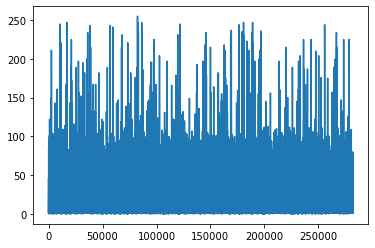

In [49]:
test['degree'].plot()

In [50]:
test['degree'].value_counts()

2      42916
5      37693
3      31033
1      28634
4      26075
       ...  
195        1
172        1
190        1
123        1
175        1
Name: degree, Length: 190, dtype: int64

In [59]:
(test['degree'] > 20).sum() / test.shape[0]

0.0810420605669326

In [64]:
other_test = pd.DataFrame(city_adj_list_away.items())
other_test = other_test.rename(columns = {0: 'node', 1: 'neighbors'})

In [66]:
other_test['degree'] = other_test['neighbors'].apply(lambda x: len(x))

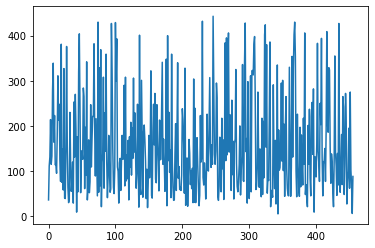

In [69]:
other_test['degree'].plot()

In [70]:
other_test['degree'].value_counts()

115    6
67     6
120    5
77     5
57     5
      ..
74     1
82     1
187    1
19     1
88     1
Name: degree, Length: 242, dtype: int64

In [80]:
(other_test['degree'] > 20).sum() / other_test.shape[0]

0.9868421052631579

In [205]:
counts = [] 

for i in range(100):
    print(i+1)
    count = sampling_count_M10(city_adj_list_away, city_adj_list_toward, 20)
    counts.append(count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [206]:
pd.Series(counts).plot(kind = 'hist')

TypeError: no numeric data to plot

In [15]:
other_counts = [] 

for i in range(100):
    print(i+1)
    other_count = sampling_count_M1(city_adj_list_away, city_adj_list_toward, 20)
    other_counts.append(other_count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


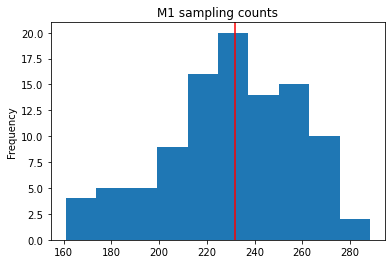

In [27]:
M1_ax = (pd.Series(other_counts)*2/3).plot(kind = 'hist')
M1_ax.set_title('M1 sampling counts')
M1_ax.axvline(x = 232, color = 'red', label = 'axvline - full height')